# Casadi example - velocity optimization/velocity planning problem

$\min\limits_{a} dt \sum\limits_{k=1}^N{v_k}$

s.t. $a_{min}<a_k<=a_{max} \forall k=1\dots N$

$0<v_k<=v_{max,k} \forall k=1\dots N$

$v_{k+1}=v_k + a_k dt \forall k=1\dots N-1$

$v_0=v0, v_N=1, a_0=0$

$a  \in \R^N, v \in \R^{N+1}$

with parameters $a_{min}, a_{max}, v_{max}$ and decision variable $a \in R^N$

For simplicity, the velocity vector is constant, such that the problem can be parametrized by 3 scalar parameters $v_{max}, a_{max}, a_{min}$

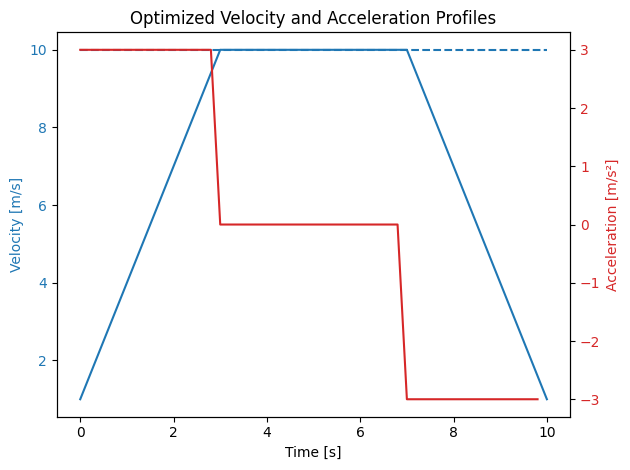

In [1]:
#from velocity_planner import velocity_planner_simple
#from velocity_planner.velocity_planner import velocity_planner_simple
#from packages.velocity_planner.velocity_planner import velocity_planner_simple
from velocity_planner import velocity_planner_simple
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 50
T = 10.0
dt = T / N
v_max = 10.0*np.ones(N+1)
#v_max[25:] = 5.0
a_max = 3.0
a_min = -3.0
v0=1.0

opti, v, a = velocity_planner_simple(N,dt,v0,v_max, a_max, a_min, opti_silent=True)
sol = opti.solve()

v_opt = sol.value(v)
a_opt = sol.value(a)
time = np.linspace(0, T, N+1)

# Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Velocity [m/s]', color='tab:blue')
ax1.plot(time, v_opt, color='tab:blue')
ax1.plot(time, v_max, color='tab:blue', linestyle='--', label='Max Velocity')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Acceleration [m/s²]', color='tab:red')
ax2.plot(time[:-1], a_opt, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Optimized Velocity and Acceleration Profiles')
plt.tight_layout()
plt.show()


# approach using Differentiable predictive control (DPC) method

as described in https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/control/Part_1_stabilize_linear_system.ipynb#scrollTo=cd824de1 or
https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/control/Part_3_ref_tracking_ODE.ipynb#scrollTo=149f7bc8

What is the main difference?

define a control system consisting of policy (the network to be trained) and the (physical, ODE) plant model
```bash
from neuromancer.system import Node, System
...
xnext = lambda x, u: x @ A.T + u @ B.T    
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
...
cl_system = System([policy, model], nsteps=nsteps)
```

so the "problem" is finally this control system
```bash
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
```
Note: here the ``loss` object contains no constraints (`[]`) - there could be constraints (as in our case) but there are no longer the dynamic constraints (`c_dyn`) we used before. These are captured by the `cl_system` as it contains the ODE (the plant model).



In [2]:
import torch
import torch.nn as nn
from neuromancer.constraint import variable
from neuromancer.system import Node, System
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dataset import DictDataset
from neuromancer.modules import blocks
import neuromancer.slim as slim

data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

/home/martgro1/pot_neuromancer_for_ocp/.venv/lib/python3.10/site-packages/mlflow/utils/requirements_utils.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
nsim = 5000
nsteps=N

spd_range = torch.distributions.Uniform(1., 10.)
spd_lim_range = torch.distributions.Uniform(10., 15.)
a_pos_range = torch.distributions.Uniform(1., a_max)
a_neg_range = torch.distributions.Uniform(a_min, -1.)

samples_train = {
    "v": spd_range.sample((nsim, 1, 1)).repeat(1, 1, 1),
    "vmax": spd_lim_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
    "amax": a_pos_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
    "amin": a_neg_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
}
samples_dev = {
    "v": spd_range.sample((nsim, 1, 1)).repeat(1, 1, 1),
    "vmax": spd_lim_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
    "amax": a_pos_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
    "amin": a_neg_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
}
samples_test = {
    "v": spd_range.sample((nsim, 1, 1)).repeat(1, 1, 1),
    "vmax": spd_lim_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
    "amax": a_pos_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
    "amin": a_neg_range.sample((nsim, 1, 1)).repeat(1, nsteps, 1),
}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)

### define plant model = kinematic model = single integrator

In [4]:
# Double integrator parameters
nx = 1
nu = 1
A = torch.tensor([[1.]])
B = torch.tensor([[dt]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['v', 'a'], ['v'], name='integrator')

### define policy

In [5]:
# neural control policy
mlp = blocks.MLP(insize=3, outsize=nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['vmax', 'amin', 'amax'], ['a'], name='policy')


#mlp = blocks.MLP(insize=3, outsize=1,
#                bias=True,
#                linear_map=slim.maps['linear'],
#                nonlin=torch.nn.ReLU,
#                hsizes=[120] * 6)
#policy = Node(mlp, ['v_max', 'a_max', 'a_min'], ['a'], name='policy')

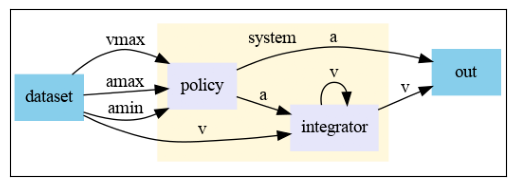

In [6]:

cl_system = System([policy, double_integrator],
                    nsteps=nsteps,
                    name='cl_system')
cl_system.show()

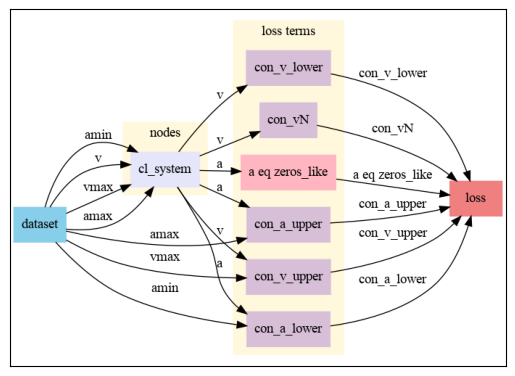

In [7]:
a = variable('a')
v = variable('v')
vmax = variable("vmax")
amax = variable("amax")
amin = variable("amin")

# constraints
con_v_lower = ( 0.01 <= v)
con_v_lower.name = 'con_v_lower'
con_v_upper = (v <= vmax)
con_v_upper.name = 'con_v_upper'
con_a_lower = (amin <= a)
con_a_lower.name = 'con_a_lower'
con_a_upper = (a <= amax)
con_a_upper.name = 'con_a_upper'

con_vN = (v[:, -1,:] == 1.0 )
con_vN.name = 'con_vN'
constraints = [con_v_lower, con_v_upper, con_a_lower, con_a_upper, con_vN]

# Objective: maximize distance → minimize -sum(v) * dt
objectives = [(a==torch.zeros_like(a))]#
#[(-torch.sum(v) * dt).minimize(name='distance')]
#objectives = [0.1 * (a[:,:-1,:] - a[:,1:,:] == 0.0) ]

# Problem formulation
nodes = [cl_system]
loss = PenaltyLoss(objectives, constraints)
problem = Problem(nodes, loss)
problem.show()


In [8]:
lr = 0.00001      # step size for gradient descent
epochs = 100    # number of training epochs
warmup = 10    # number of epochs to wait before enacting early stopping policy
patience = 10  # number of epochs with no improvement in eval metric to allow before early stopping

optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=warmup)

In [9]:
best_model = trainer.train()
best_outputs = trainer.test(best_model)
problem.load_state_dict(best_model)

RuntimeError: The size of tensor a (51) must match the size of tensor b (50) at non-singleton dimension 1